# **PicoScope**: analysis of scattering profile

<span style="color:gold">
    <font size="6">
        <b>gold</b>
    </font>
</span>

## Preliminary operations

### Flags

In [1]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False
SAVE_DATA     = False

### Load packages

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

### Settings

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

## Convert waveform files to numpy array and store

### Path to data

In [4]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/gold"

### Unzip all data archives and get number of events

In [5]:
if UNZIP_DATA:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists("data"):
            os.system("unzip data.zip -d data")
        os.chdir("../")

### Convert to numpy array

In [6]:
if WAVE2NUMPY:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists(d+".npy"):
            N = len(os.listdir("./data"))
            M = 5000

            data = np.zeros((N,M),dtype=np.int16)
            for f,i in zip(os.listdir("./data"), range(N)):
                data[i,:] = np.loadtxt("./data/run_"+str(i)+"_segment_0.rpsd")
            np.save(d+".npy", data)

        os.chdir("../")

## Analysis

In [7]:
M  = 20    # moving average (MAV) filter M
SC = 33    # picoscoper center in steps

### Collect data angle

In [8]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    # print(d)
    os.chdir(d)
    run = d.split("_")[0]
    
    #######################################################################
    # TAKE DIRECTION FROM DIR NAME
    #######################################################################
    if "DC" in d:
        sign = -1
    elif "SC" in d:
        sign = +1
    else:
        sign = 0
    #######################################################################

    #######################################################################
    # TAKE DATA FROM run FILE
    #######################################################################
    file = open("run")
    line = file.readlines()
    for l in line:
        if (l.startswith("n_segments")):
            n_seg = int(l.split('=')[1].strip())
            pico_seg.append(n_seg)
        if (l.startswith("run_time")):
            run_time = int(l.split('=')[1].strip())
    file.close()
    
    steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) - SC
    #######################################################################
    
    #######################################################################
    # TAKE DATA FROM run_BlockTimes.txt
    #######################################################################
    times  = np.loadtxt("run_BlockTimes.txt")
    blocks = times.shape[0]
    events = blocks * n_seg
    # print(times.shape)
    if times.shape != (2,):
        t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
    else:
        t  = run_time

    pico_step.append(steps)
    pico_rad.append(steps * 0.9 * np.pi / 180.0)
    pico_deg.append(steps * 0.9)
    pico_t.append(t)
    pico_ev.append(events)
    pico_r.append(events / t * 3600)
    #######################################################################
    
    #######################################################################
    # COMPUTE ERRORS
    #######################################################################
    pico_step_err.append(0.05) # 1.0 / np.sqrt(12.0)
    pico_rad_err .append(0.05 * 0.9 * np.pi / 180.0)
    pico_deg_err .append(0.05 * 0.9)
    pico_ev_err  .append(np.sqrt(events))
    pico_r_err   .append(np.sqrt(events) / t * 3600)
    #######################################################################

    
    #######################################################################
    # TAKE DATA FROM ALL WAVEFORMS
    #######################################################################
    if WAVE2NUMPY:
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        if REJECT_3SIGMA:
            mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
            mask_f = np.logical_not(mask_t)
        else:
            mask_t = np.ones(data_mav_int.shape, dtype=bool)
            mask_f = np.logical_not(mask_t)

        if PLOT_WAVE:
            fig=plt.figure(figsize=(12, 4))
            plt.subplot(1,2,1)
            if mask_f.shape[0] != 0:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
            else:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.title(d)

            plt.subplot(1,2,2)
            if mask_f.shape[0] != 0:
                plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
            else:
                plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
            plt.yscale("log")
            plt.title(d)
            plt.show()
    #######################################################################

    os.chdir(DATA_PATH)

### Events distribution

In [9]:
col = palette.brewer['RdYlGn'][10]

In [10]:
d = {
    "pico_step"     : pico_step,
    "pico_rad"      : pico_rad,
    "pico_deg"      : pico_deg,
    "pico_seg"      : pico_seg,
    "pico_ev"       : pico_ev,
    "pico_t"        : pico_t,
    "pico_r"        : pico_r,
    "pico_step_err" : pico_step_err,
    "pico_rad_err"  : pico_rad_err,
    "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : pico_ev_err,
    "pico_r_err"    : pico_r_err
}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['pico_step'])

In [11]:
df = df.groupby(["pico_step", "pico_rad", "pico_deg", "pico_seg", "pico_step_err", "pico_rad_err", "pico_deg_err"], as_index=False).sum()

df["pico_r"]      = df["pico_ev"] / df["pico_t"] * 3600
df["pico_ev_err"] = np.sqrt(df["pico_ev"])
df["pico_r_err"]  = df["pico_ev_err"] / df["pico_t"] * 3600

In [12]:
df

,pico_step,pico_rad,pico_deg,pico_seg,pico_step_err,pico_rad_err,pico_deg_err,pico_ev,pico_t,pico_r,pico_ev_err,pico_r_err
0,-60,-0.942478,-54.0,1,0.05,0.000785,0.045,303,174966.369999,6.234341,17.406895,0.358154
1,-50,-0.785398,-45.0,1,0.05,0.000785,0.045,254,133428.859999,6.853090,15.937377,0.430001
2,-40,-0.628319,-36.0,1,0.05,0.000785,0.045,174,86572.940000,7.235517,13.190906,0.548523
3,-35,-0.549779,-31.5,1,0.05,0.000785,0.045,127,43494.490000,10.511676,11.269428,0.932760
4,-30,-0.471239,-27.0,1,0.05,0.000785,0.045,52,18678.880000,10.022014,7.211103,1.389803
5,-28,-0.439823,-25.2,1,0.05,0.000785,0.045,79,18152.120000,15.667591,8.888194,1.762742
6,-26,-0.408407,-23.4,1,0.05,0.000785,0.045,88,18657.530000,16.979740,9.380832,1.810046
7,-24,-0.376991,-21.6,1,0.05,0.000785,0.045,72,10887.079999,23.808037,8.485281,2.805804
8,-22,-0.345575,-19.8,1,0.05,0.000785,0.045,83,10831.680000,27.585748,9.110434,3.027929
9,-20,-0.314159,-18.0,10,0.05,0.000785,0.045,120,7614.090000,56.736918,10.954451,5.179348


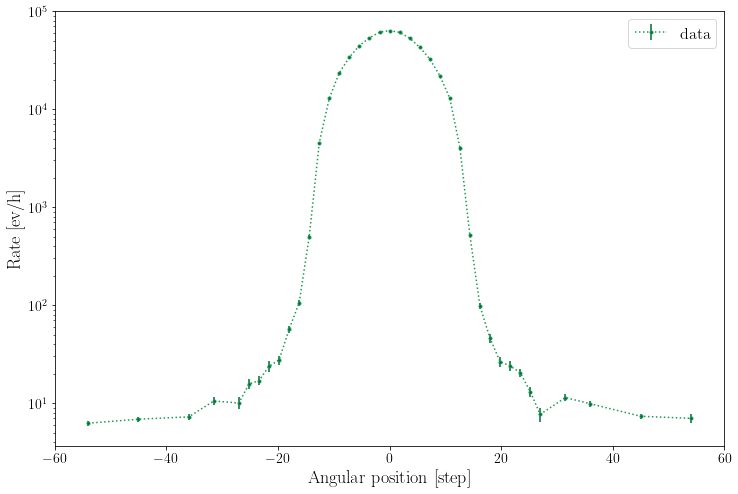

In [13]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.errorbar(df["pico_deg"],
             df["pico_r"],
             #xerr=df["pico_step_err"],
             yerr=df["pico_r_err"],
             fmt=':o',
             markerfacecolor=col[0],
             color=col[1],
             ecolor=col[0],
             label="data",
             alpha=1,
             markersize=3) #fillstyle="none"
plt.xlabel("Angular position [step]")
plt.ylabel("Rate [ev/h]")
plt.xlim(-60,60)
plt.legend()
plt.show()

## Save data

In [14]:
data = np.column_stack((np.array(df["pico_step"], dtype=np.int32), np.array(df["pico_r"]), np.array(df["pico_r_err"])))

In [15]:
if SAVE_DATA:
    np.savetxt("pico_data_gold.txt", data)

***

<br>
<br>
<br>
<br>
<br>

***

# **PicoScope**: analysis of scattering profile

<span style="color:gray">
    <font size="6">
        <b>tin</b>
    </font>
</span>

## Preliminary operations

### Flags

In [16]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False
SAVE_DATA     = False

### Load packages

In [17]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

### Settings

In [18]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

## Convert waveform files to numpy array and store

### Path to data

In [19]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/tin"

### Unzip all data archives and get number of events

In [20]:
if UNZIP_DATA:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists("data"):
            os.system("unzip data.zip -d data")
        os.chdir("../")

### Convert to numpy array

In [21]:
if WAVE2NUMPY:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists(d+".npy"):
            N = len(os.listdir("./data"))
            M = 5000

            data = np.zeros((N,M),dtype=np.int16)
            for f,i in zip(os.listdir("./data"), range(N)):
                data[i,:] = np.loadtxt("./data/run_"+str(i)+"_segment_0.rpsd")
            np.save(d+".npy", data)

        os.chdir("../")

## Analysis

In [22]:
M  = 20    # moving average (MAV) filter M
SC = 33    # picoscoper center in steps

### Collect data angle

In [23]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    # print(d)
    os.chdir(d)
    run = d.split("_")[0]
    
    #######################################################################
    # TAKE DIRECTION FROM DIR NAME
    #######################################################################
    if "DC" in d:
        sign = -1
    elif "SC" in d:
        sign = +1
    else:
        sign = 0
    #######################################################################

    #######################################################################
    # TAKE DATA FROM run FILE
    #######################################################################
    file = open("run")
    line = file.readlines()
    for l in line:
        if (l.startswith("n_segments")):
            n_seg = int(l.split('=')[1].strip())
            pico_seg.append(n_seg)
        if (l.startswith("run_time")):
            run_time = int(l.split('=')[1].strip())
    file.close()
    
    steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) - SC
    #######################################################################
    
    #######################################################################
    # TAKE DATA FROM run_BlockTimes.txt
    #######################################################################
    times  = np.loadtxt("run_BlockTimes.txt")
    blocks = times.shape[0]
    events = blocks * n_seg
    # print(times.shape)
    if times.shape != (2,):
        t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
    else:
        t  = run_time

    pico_step.append(steps)
    pico_rad.append(steps * 0.9 * np.pi / 180.0)
    pico_deg.append(steps * 0.9)
    pico_t.append(t)
    pico_ev.append(events)
    pico_r.append(events / t * 3600)
    #######################################################################
    
    #######################################################################
    # COMPUTE ERRORS
    #######################################################################
    pico_step_err.append(0.05) # 1.0 / np.sqrt(12.0)
    pico_rad_err .append(0.05 * 0.9 * np.pi / 180.0)
    pico_deg_err .append(0.05 * 0.9)
    pico_ev_err  .append(np.sqrt(events))
    pico_r_err   .append(np.sqrt(events) / t * 3600)
    #######################################################################

    
    #######################################################################
    # TAKE DATA FROM ALL WAVEFORMS
    #######################################################################
    if WAVE2NUMPY:
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        if REJECT_3SIGMA:
            mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
            mask_f = np.logical_not(mask_t)
        else:
            mask_t = np.ones(data_mav_int.shape, dtype=bool)
            mask_f = np.logical_not(mask_t)

        if PLOT_WAVE:
            fig=plt.figure(figsize=(12, 4))
            plt.subplot(1,2,1)
            if mask_f.shape[0] != 0:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
            else:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.title(d)

            plt.subplot(1,2,2)
            if mask_f.shape[0] != 0:
                plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
            else:
                plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
            plt.yscale("log")
            plt.title(d)
            plt.show()
    #######################################################################

    os.chdir(DATA_PATH)

### Events distribution

In [24]:
col = palette.brewer['RdYlGn'][10]

In [25]:
d = {
    "pico_step"     : pico_step,
    "pico_rad"      : pico_rad,
    "pico_deg"      : pico_deg,
    "pico_seg"      : pico_seg,
    "pico_ev"       : pico_ev,
    "pico_t"        : pico_t,
    "pico_r"        : pico_r,
    "pico_step_err" : pico_step_err,
    "pico_rad_err"  : pico_rad_err,
    "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : pico_ev_err,
    "pico_r_err"    : pico_r_err
}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['pico_step'])

In [26]:
df = df.groupby(["pico_step", "pico_rad", "pico_deg", "pico_seg", "pico_step_err", "pico_rad_err", "pico_deg_err"], as_index=False).sum()

df["pico_r"]      = df["pico_ev"] / df["pico_t"] * 3600
df["pico_ev_err"] = np.sqrt(df["pico_ev"])
df["pico_r_err"]  = df["pico_ev_err"] / df["pico_t"] * 3600

In [27]:
df

,pico_step,pico_rad,pico_deg,pico_seg,pico_step_err,pico_rad_err,pico_deg_err,pico_ev,pico_t,pico_r,pico_ev_err,pico_r_err
0,-50,-0.785398,-45.0,1,0.05,0.000785,0.045,234,130222.830000,6.468912,15.297059,0.422886
1,-40,-0.628319,-36.0,1,0.05,0.000785,0.045,187,86573.670001,7.776036,13.674794,0.568640
2,-35,-0.549779,-31.5,1,0.05,0.000785,0.045,83,43215.730000,6.914149,9.110434,0.758926
3,-30,-0.471239,-27.0,1,0.05,0.000785,0.045,54,19038.040000,10.211135,7.348469,1.389559
4,-28,-0.439823,-25.2,1,0.05,0.000785,0.045,75,19076.900000,14.153243,8.660254,1.634276
5,-26,-0.408407,-23.4,1,0.05,0.000785,0.045,95,18020.560001,18.978323,9.746794,1.947135
6,-24,-0.376991,-21.6,1,0.05,0.000785,0.045,67,10878.630000,22.171910,8.185353,2.708730
7,-22,-0.345575,-19.8,1,0.05,0.000785,0.045,106,10874.529999,35.091172,10.295630,3.408356
8,-20,-0.314159,-18.0,10,0.05,0.000785,0.045,110,7485.610000,52.901500,10.488088,5.043960
9,-18,-0.282743,-16.2,10,0.05,0.000785,0.045,250,7208.770000,124.847928,15.811388,7.896076


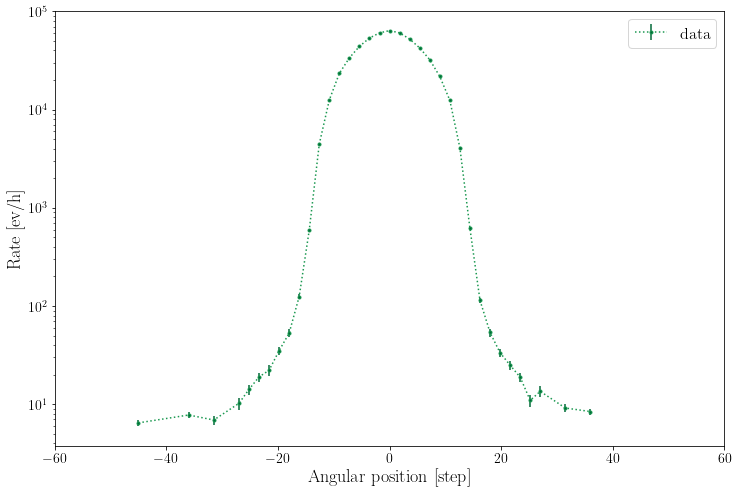

In [28]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.errorbar(df["pico_deg"],
             df["pico_r"],
             #xerr=df["pico_step_err"],
             yerr=df["pico_r_err"],
             fmt=':o',
             markerfacecolor=col[0],
             color=col[1],
             ecolor=col[0],
             label="data",
             alpha=1,
             markersize=3) #fillstyle="none"
plt.xlabel("Angular position [step]")
plt.ylabel("Rate [ev/h]")
plt.xlim(-60,60)
plt.legend()
plt.show()

## Save data

In [29]:
data = np.column_stack((np.array(df["pico_step"], dtype=np.int32), np.array(df["pico_r"]), np.array(df["pico_r_err"])))

In [30]:
if SAVE_DATA:
    np.savetxt("pico_data_tin.txt", data)